In [56]:
##capture
!pip install groq

In [57]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
from groq import Groq
client = Groq()

In [58]:
# def generate_content(prompt):
#     response = client.chat.completions.create(
#         messages=[{"role": "user", "content": prompt}],
#         model="llama3-groq-70b-8192-tool-use-preview"#"llama-3.1-8b-instant"
#     )
#     return response

# KG-RAG

## Prepare Your Documents

## Upload the json file

In [59]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your JSON file

Saving test.json to test (2).json


In [60]:
import json

# Load the JSON content from 'parameters.json' (replace with your file name)
with open('test.json', 'r') as f:
    data = json.load(f)

## Generate the documents

In [61]:
documents = []

def extract_text_from_dict(d):
    text_content = ""
    if isinstance(d, dict):
        for key, value in d.items():
            if key in ['doc', 'explanation', 'conditions', 'extra', 'description']:
                text_content += str(value) + "\n"
            elif isinstance(value, dict):
                text_content += extract_text_from_dict(value)
            elif isinstance(value, list):
                for item in value:
                    text_content += extract_text_from_dict(item)
    return text_content

for key, value in data.items():
    if isinstance(value, dict):
        text_content = extract_text_from_dict(value)
        if text_content:
            documents.append(text_content)
    elif isinstance(value, str):
        documents.append(value)


## Extract Triples from Documents
### Don't use a big file if you don't have a paid API for the LLM

In [62]:
def generate_knowledge_graph(text):
    prompt = f"""
Extract entities and relationships from the following text and present them as a JSON array of triples (subject, predicate, object). Output **only** the JSON array, without any additional text.

Text:
{text}

Output:
"""
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama3-groq-70b-8192-tool-use-preview",
        temperature=0
    )
    return response


In [63]:
import re
import json

all_triples = []

for idx, doc in enumerate(documents):
    output = generate_knowledge_graph(doc)
    content = output.choices[0].message.content.strip()

    # Extract JSON array from the content
    json_data = re.search(r'\[.*\]', content, re.DOTALL)
    if json_data:
        json_text = json_data.group(0)
    else:
        print(f"No JSON array found in the model's output for document {idx}.")
        json_text = content  # Fallback to using the entire content

    # Replace single quotes with double quotes (if necessary)
    json_text = json_text.replace("'", '"')

    try:
        triples = json.loads(json_text)
        all_triples.extend(triples)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON for document {idx}:", e)
        print("Model output was:", content)

Failed to parse JSON for document 1: Expecting ',' delimiter: line 4 column 160 (char 558)
Model output was: [
  {"subject": "ATOMIC_SPECIES", "predicate": "Syntax", "object": "X(1) Mass_X(1) PseudoPot_X(1) X(2) Mass_X(2) PseudoPot_X(2) X(ntyp) Mass_X(ntyp) PseudoPot_X(ntyp)"},
  {"subject": "X", "predicate": "Description", "object": "chemical symbol X (1 or 2 characters, case-insensitive) or chemical symbol plus a number or a letter, as in Fe1 or C1, C_h; max total length cannot exceed 3 characters"},
  {"subject": "Mass_X", "predicate": "Description", "object": "mass of the atomic species [amu: mass of C = 12] Used only when performing Molecular Dynamics ('md') run or structural optimization runs using Damped MD. Not actually used in all other cases (but stored in data files, so phonon calculations will use these values unless other values are provided)"},
  {"subject": "PseudoPot_X", "predicate": "Description", "object": "File containing PP for this species."}
]
Failed to parse JSON

## Build the Knowledge Graph

In [64]:
import networkx as nx

KG = nx.DiGraph()

for triple in all_triples:
    subject = triple['subject']
    predicate = triple['predicate']
    obj = triple['object']
    KG.add_edge(subject, obj, label=predicate)


## Extract Entities from User Query

In [65]:
def extract_entities_from_query(query):
    prompt = f"""
Extract the entities from the following query:

Query:
{query}

Entities (provide a comma-separated list):
"""
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama3-groq-70b-8192-tool-use-preview",
        temperature=0
    )
    content = response.choices[0].message.content.strip()
    # Parse the entities
    entities = [entity.strip() for entity in content.split(',') if entity.strip()]
    return entities

## Retrieve Relevant Knowledge

In [66]:
def retrieve_knowledge(entities, KG):
    subgraph = nx.DiGraph()
    for entity in entities:
        if entity in KG.nodes:
            # Outgoing edges
            for neighbor in KG.successors(entity):
                predicate = KG.edges[entity, neighbor]['label']
                subgraph.add_edge(entity, neighbor, label=predicate)
            # Incoming edges
            for predecessor in KG.predecessors(entity):
                predicate = KG.edges[predecessor, entity]['label']
                subgraph.add_edge(predecessor, entity, label=predicate)
    return subgraph

## Generate Answer

In [67]:
def generate_answer(query, knowledge_subgraph):
    # Convert the subgraph into text
    knowledge_statements = []
    for u, v, data in knowledge_subgraph.edges(data=True):
        knowledge_statements.append(f"{u} {data['label']} {v}.")
    knowledge_text = "\n".join(knowledge_statements)

    prompt = f"""
Answer the following question using the provided knowledge.

Question:
{query}

Knowledge:
{knowledge_text}

Answer:
"""
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama3-groq-70b-8192-tool-use-preview",
        temperature=0
    )
    content = response.choices[0].message.content.strip()
    return content

## Augment the Language Model's Response

## Example

In [68]:
query = "What is the default value of ibrav?"

In [69]:
entities = extract_entities_from_query(query)
print("Extracted Entities:", entities)

Extracted Entities: ['ibrav']


In [70]:
knowledge_subgraph = retrieve_knowledge(entities, KG)

In [71]:
answer = generate_answer(query, knowledge_subgraph)
print("Answer:", answer)

Answer: The default value of ibrav is 0.


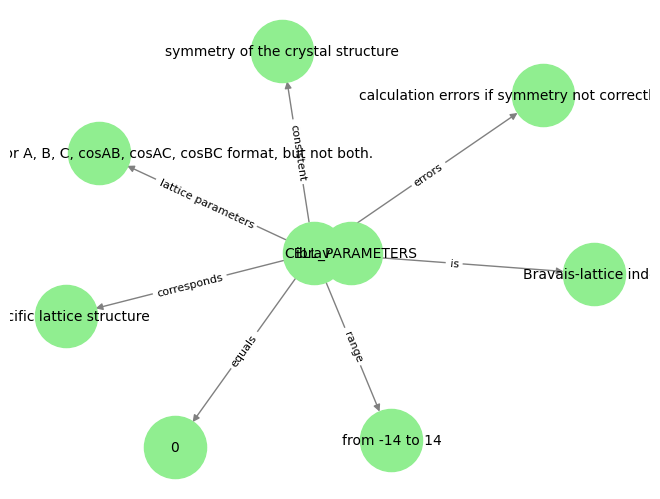

In [72]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(knowledge_subgraph)
edge_labels = nx.get_edge_attributes(knowledge_subgraph, 'label')
nx.draw(knowledge_subgraph, pos, with_labels=True, node_color='lightgreen', node_size=2000, edge_color='gray', linewidths=1, font_size=10)
nx.draw_networkx_edge_labels(knowledge_subgraph, pos, edge_labels=edge_labels, font_size=8)
plt.show()